# Example
Comparison between swept wing by Bertin and pySailingVLM results. More information can be found at Aerodynamics for engineers John J.Bertin p 368 (Example 7.2).

In [101]:
# varaibles.py for jupyter
import os
import numpy as np
import time

AR = 4 
half_wing_span = 0.5
chord_length = half_wing_span / AR
sweep_angle_deg = 45.
AoA_deg = 5.
mgirths =  np.array([0.00, 1./8, 1./4, 1./2, 3./4, 7./8, 1.00])
mchords = np.array([chord_length]* len(mgirths))

   
output_args = {
    'case_name': 'my_case_name',  # get name of the current file
    'case_dir': os.path.abspath(''), # get dir of the current file
    'name': os.path.join("results_example_jib_and_mainsail_vlm", time.strftime("%Y-%m-%d_%Hh%Mm%Ss")),
    'file_name': 'my_fancy_results', # name of xlsx excel file
}

solver_args = {
    'n_spanwise':  3,  # No of control points (above the water) per sail, recommended: 50
    'n_chordwise': 2, # No of control points (above the water) per sail, recommended: 50
    'interpolation_type': "linear",  # either "spline" or "linear"
    'LLT_twist': "real_twist",  # defines how the Lifting Line discretize the sail twist.
}

conditions_args = {
    'leeway_deg': 0.,    # [deg]
    'heel_deg': 0.,     # [deg]
    'SOG_yacht': 0.,   # [m/s] yacht speed - speed over ground (leeway is a separate variable)
    'tws_ref': 1.0,     # [m/s] true wind speed
    'alpha_true_wind_deg': AoA_deg,   # [deg] true wind angle (with reference to course over ground) => Course Wind Angle to the boat track = true wind angle to centerline + Leeway
    'reference_water_level_for_wind_profile': -0.,  # [m] this is an attempt to mimick the deck effect
    # by lowering the sheer_above_waterline
    # while keeping the wind profile as in original geometry
    # this shall be negative (H = sail_ctrl_point - water_level)
    'wind_exp_coeff': 0.,  # [-] coefficient to determine the exponential wind profile
    'wind_reference_measurment_height': 10.,  # [m] reference height for exponential wind profile
    'rho': 1.,  # air density [kg/m3]
    'wind_profile': 'flat', # allowed: 'exponential' or 'flat' or 'logarithmic'
    'roughness': 0.05, # for logarithmic profile only 
}


rig_args = {
    'main_sail_luff': half_wing_span / np.cos(np.deg2rad(sweep_angle_deg)),  # [m]
    'jib_luff': 10.0,  # [m]
    'foretriangle_height': 11.50,  # [m]
    'foretriangle_base': 3.90,  # [m]
    'sheer_above_waterline': 0.,#[m]
    'boom_above_sheer': 0., # [m],
    'rake_deg': 90. + sweep_angle_deg,  # rake angle [deg]
    'mast_LOA': 0.,  # [m]
    'sails_def': 'main', # definition of sail set, possible: 'jib' or 'main' or 'jib_and_main'
}


# INFO for camber:
# First digit describing maximum camber as percentage of the chord.
# Second digit describing the distance of maximum camber from the airfoil leading edge in tenths of the chord.
main_sail_args = {
    'girths' : mgirths,
    'chords': mchords,
    'centerline_twist_deg': 0*mgirths,
    'camber': 0*np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]),
    'camber_distance_from_luff': np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]),
}
 

jgirths = np.array([0.00, 1./4, 1./2, 3./4, 1.00])
jib_sail_args = {
    'centerline_twist_deg': 0*(10+5)  + 0*15. * jgirths,
    'girths': jgirths,
    'chords': 0* np.array([3.80, 2.98, 2.15, 1.33, 0.5]),
    'camber': 0*np.array([0.01, 0.01, 0.01, 0.01, 0.01]),
    'camber_distance_from_luff': np.array([0.5, 0.5, 0.5, 0.5, 0.5]), # starting from leading edge   
}        

# REFERENCE CSYS
# The origin of the default CSYS is located @ waterline level and aft face of the mast
# The positive x-coord: towards stern
# The positive y-coord: towards leeward side
# The positive z-coord: above the water
# To shift the default CSYS, adjust the 'reference_level_for_moments' variable.
# Shifted CSYS = original + reference_level_for_moments
# As a results the moments will be calculated around the new origin.

# yaw_reference [m] - distance from the aft of the mast towards stern, at which the yawing moment is calculated.
# sway_reference [m] - distance from the aft of the mast towards leeward side. 0 for symmetric yachts ;)
# heeling_reference [m] - distance from the water level,  at which the heeling moment is calculated.
csys_args = {
    'reference_level_for_moments': np.array([0, 0, 0]),  # [yaw_reference, sway_reference, heeling_reference]
}

# GEOMETRY OF THE KEEL
# to estimate heeling moment from keel, does not influence the optimizer.
# reminder: the z coord shall be negative (under the water)
keel_args={
    'center_of_lateral_resistance_upright': np.array([0, 0, -1.0]),  # [m] the coordinates for a yacht standing in upright position
}  


<div class="alert alert-block alert-warning">
<b>Run cell below twice:</b> Run cell below twice before running other cells. Output below is expected to always appear at first time importing pySailingVLM:
<br><br>
    
<em>   
/home/user/miniconda3/envs/mgr_test/lib/python3.10/site-packages/numba/core/lowering.py:107: NumbaDebugInfoWarning: Could not find source for function: <function __numba_array_expr_0x7f01d6a1e9e0 at 0x7f01d6cfa680>. Debug line information may be inaccurate.warnings.warn(NumbaDebugInfoWarning(msg))
</em> 
<br>
</div>

In [102]:
import shutil
from pySailingVLM.rotations.csys_transformations import CSYS_transformations
from pySailingVLM.yacht_geometry.hull_geometry import HullGeometry
from pySailingVLM.results.save_utils import save_results_to_file
from pySailingVLM.solver.panels_plotter import display_panels_xyz_and_winds
from pySailingVLM.results.inviscid_flow import InviscidFlowResults
from pySailingVLM.solver.vlm import Vlm
from pySailingVLM.runner.sail import Wind, Sail
from pySailingVLM.runner.container import Output, Rig, Conditions, Solver, MainSail, JibSail, Csys, Keel

from pySailingVLM.solver.panels_plotter import plot_cp

In [168]:
import numpy as np
from pySailingVLM.solver.coefs import get_vlm_Cxyz


sweep_angle_degs = [0]#[0, 45, 135]

# cav = s_wing / span = chord_length
cav = chord_length
C = []
c_l = []
a_vlm = []

solver = Solver(**solver_args)
conditions = Conditions(**conditions_args)
out = Output(**output_args) 
main = MainSail(**main_sail_args)
jib = JibSail(**jib_sail_args)
csys = Csys(**csys_args)
keel = Keel(**keel_args)
csys_transformations = CSYS_transformations(conditions.heel_deg, conditions.leeway_deg, v_from_original_xyz_2_reference_csys_xyz=csys.reference_level_for_moments)
w = Wind(conditions)

for sweep_angle_deg in sweep_angle_degs:

    rig_args['rake_deg']= 90. + sweep_angle_deg
    rig = Rig(**rig_args)
    
    s = Sail(solver, rig, main, jib, csys_transformations)
    sail_set = s.sail_set
    myvlm = Vlm(sail_set.panels, solver.n_chordwise, solver.n_spanwise, conditions.rho, w.profile, sail_set.trailing_edge_info, sail_set.leading_edge_info)

    height = 1.0
    sails_Cxyz = myvlm.get_Cxyz(w, height)
    
    # ln per panel
    # ln = rho * u_oo * Gamma_n
    l = np.asarray([(myvlm.rho * np.linalg.norm(w.profile.get_true_wind_speed_at_h(height)) * gamma_n) for gamma_n in myvlm.gamma_magnitude])
    cl = np.asarray([ln / (0.5 * myvlm.rho * np.linalg.norm(w.profile.get_true_wind_speed_at_h(height))**2 *cav) for ln in l])
    cl2 = np.asarray([ 2 * gamma_n / (np.linalg.norm(w.profile.get_true_wind_speed_at_h(height)) * cav)for gamma_n in myvlm.gamma_magnitude])

    CL = 2 * np.sum(myvlm.gamma_magnitude*myvlm.span_vectors[:,2] ) / (np.linalg.norm(w.profile.get_true_wind_speed_at_h(height)) * np.sum(myvlm.areas))
    # sam main jest

    for idx, Cxyz in enumerate(sails_Cxyz):
        a = Cxyz[1] / np.deg2rad(AoA_deg)
        C.append(Cxyz[1])
        a_vlm.append(a)

In [159]:
np.testing.assert_almost_equal(cl, cl2)
cl_1, cl_2 = np.split(cl, 2)
cl_1_resh = cl_1.reshape(solver.n_chordwise, solver.n_spanwise)
cl_2_resh = cl_2.reshape(solver.n_chordwise, solver.n_spanwise)
cl_2_flipp = np.fliplr(cl_2_resh.reshape(solver.n_chordwise, solver.n_spanwise))
np.testing.assert_almost_equal(sorted(cl_1), sorted(cl_2))
np.testing.assert_almost_equal(cl_1_resh, cl_2_flipp)

In [169]:
CL / np.deg2rad(AoA_deg)
a_vlm

[5.286107639106136]

In [72]:
cl_1_resh

array([[0.2695066 , 0.26912691, 0.26834316, 0.26710302],
       [0.26531819, 0.26284947, 0.25948038, 0.25486911],
       [0.24845668, 0.23927554, 0.22549391, 0.20306113],
       [0.15960441, 0.3845694 , 0.3840092 , 0.38285198],
       [0.38101861, 0.37837511, 0.37470947, 0.36969007],
       [0.36278962, 0.35313813, 0.33921389, 0.31810525],
       [0.28334887, 0.21593746, 0.4533587 , 0.45268051],
       [0.45127883, 0.44905611, 0.44584693, 0.44138876],
       [0.43526954, 0.42683125, 0.41498306, 0.39780906],
       [0.37164282, 0.32846156, 0.24592751, 0.49144749],
       [0.49069912, 0.48915187, 0.48669698, 0.48314975],
       [0.47821672, 0.47143644, 0.46207066, 0.44889359],
       [0.42975164, 0.40054066, 0.35241922, 0.261635  ]])

In [51]:
N = int(sail_set.panels.shape[0] / 2)
cav = chord_length
y_data = np.array([calculate_ydata(myvlm.gamma_magnitude[i], C[0], cav, w, height) for i in range(N)])
cp_y = np.split(myvlm.cp, 2)[0][:,2]
x_data = 2 * cp_y / (half_wing_span * 2)

In [74]:
a = np.array([calculate_ydata(myvlm.gamma_magnitude[i], C[0], cav, w, height) for i in range(N)])
b = np.split(a, solver.n_spanwise)
y_data = [np.sum(c) for c in b]

cp_y = np.split(myvlm.cp, 2)[0][:,2]
x_data = 2 * cp_y.reshape(solver.n_spanwise, solver.n_chordwise)[:, 0] / (half_wing_span * 2)


array([0.08838835, 0.44194174, 0.08838835, 0.44194174])

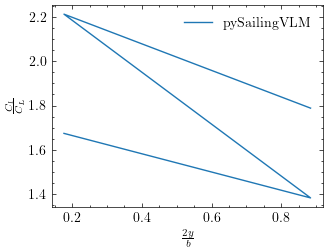

In [75]:
# importing matplotlib module
from matplotlib import pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(x_data, y_data, color='tab:blue', label='pySailingVLM')
#ax.plot(x_good, ydata_good, color='tab:orange', linestyle='dashed', label='Bertin')

ax.set_xlabel(r"$\frac{2y}{b}$")
ax.set_ylabel(r"$\frac{C_{l}}{C_{L}}$")
#ax.set_title("Spanwise lift distribution")
ax.legend()   